In [1]:
!pip install pandas numpy nltk scikit-learn

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [3]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Load the dataset

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"subhiksha28","key":"7d8165e0e1d3e41d6ff1eb88b707c82a"}'}

In [5]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d kazanova/sentiment140
!unzip sentiment140.zip

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 88% 71.0M/80.9M [00:00<00:00, 108MB/s] 
100% 80.9M/80.9M [00:00<00:00, 103MB/s]
Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [7]:
# Load the dataset
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)

# Assign column names
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

In [8]:
#Info of the dataset
print('length of data is', len(df))

length of data is 1600000


In [9]:
df.info()

#Check for missing values
df.isna().sum()

# Check for duplicates
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)

# Drop duplicate rows if any
df = df.drop_duplicates()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB
Number of duplicate rows: 0


Sampling of data

In [12]:
# Filter the dataset for positive and negative samples
positive_samples = df[df['target'] == 4]
negative_samples = df[df['target'] == 0]

# Sample an equal number of positives and negatives
n_samples = 1000
positive_sampled = positive_samples.sample(n=n_samples, random_state=1)
negative_sampled = negative_samples.sample(n=n_samples, random_state=1)

# Combine and shuffle the samples
senti140_reduced = pd.concat([positive_sampled, negative_sampled]).sample(frac=1, random_state=1).reset_index(drop=True)

print("Balanced dataset created with {} positive and {} negative samples.".format(n_samples, n_samples))

Balanced dataset created with 1000 positive and 1000 negative samples.


In [13]:
# Keep only the 'target' and 'text' columns
senti140_reduced = senti140_reduced[['target', 'text']]
senti140_reduced.head()

,target,text
0,4,ello new follower.
1,0,@nikkibop @troykids i wish i could listen but...
2,0,@MzKikiJ Aww...now i'm sad!!! We didn't go b/c...
3,0,"@jessickak haha k i will when i get home, i le..."
4,0,Sirens are going off


Pre-Processing

In [14]:
# Define the text cleaning Regex
TEXT_CLEANING_RE = "@\w+|https?://\S+|[^A-Za-z0-9]+"

# Initialize Lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Pre-process function
def preprocess(text):
    # Remove link, user, and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(lemmatizer.lemmatize(token))
    return " ".join(tokens)

# Apply preprocessing to the text data
senti140_reduced['text'] = senti140_reduced['text'].apply(preprocess)

In [15]:
senti140_reduced.head()

,target,text
0,4,ello new follower
1,0,troykids wish could listen service 6 buck mont...
2,0,aww sad go b c weather channel said gonna rain...
3,0,haha k get home left phone room woops
4,0,siren going


Vectorize the data

In [16]:
# Vectorize the text data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(senti140_reduced['text'])

# Labels (0 for negative, 1 for positive)
y = senti140_reduced['target'].apply(lambda x: 1 if x == 4 else 0)

Splitting the data

In [17]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Train the model

In [18]:
# Train a Naive Bayes classifier
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

Prediction

In [19]:
# Predict on the test set
y_pred = nb.predict(X_test)

Evaluate the model

In [20]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.67


In [21]:
#Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.67      0.64       175
           1       0.72      0.67      0.70       225

    accuracy                           0.67       400
   macro avg       0.67      0.67      0.67       400
weighted avg       0.67      0.67      0.67       400



Visualization

Distribution of Sentiments

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

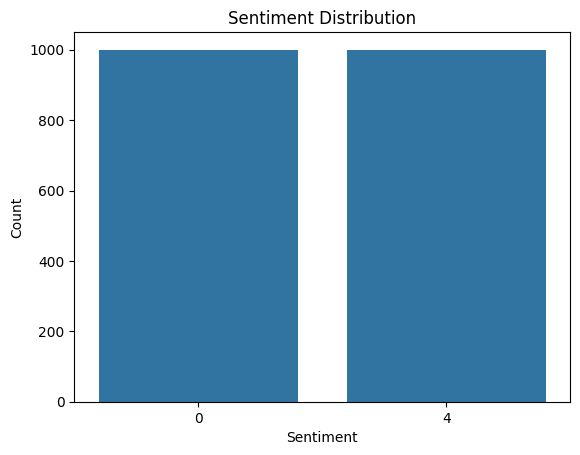

In [23]:
sns.countplot(x='target', data=senti140_reduced)  # Add the 'data' argument
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

Model Performance

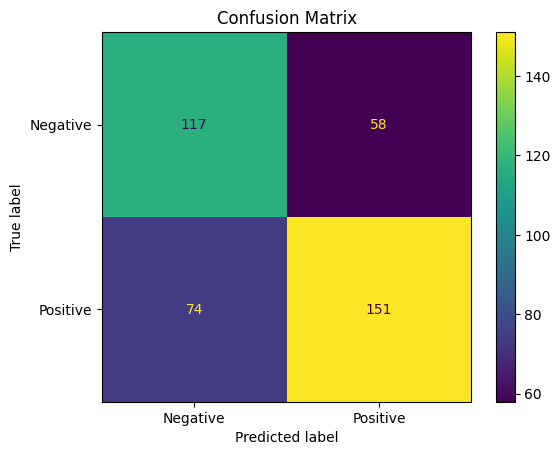

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Negative', 'Positive'])
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

ROC Curve and AUC

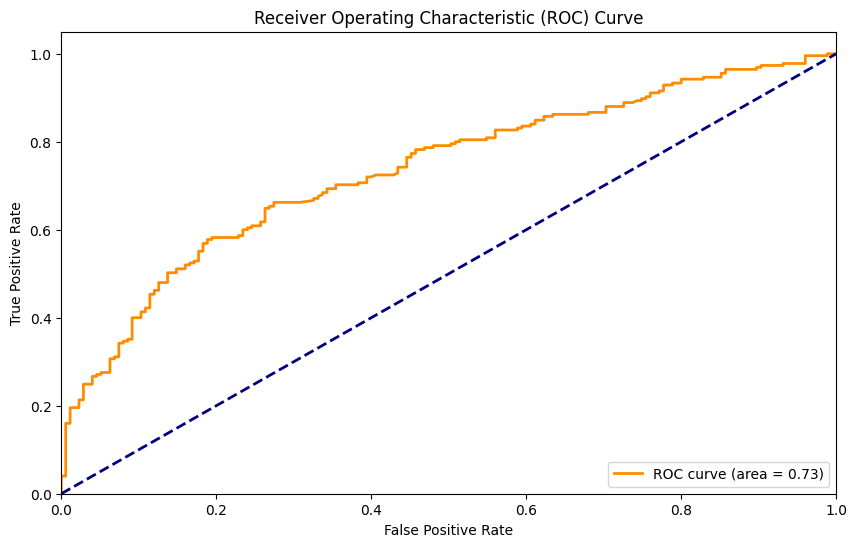

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the probability scores
y_proba = nb.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
